# SITCOM-1118 Slewing in Azimuth Analysis - Positioning

To analyze the positioning system after a slew in azimuth

This is very similar to the SITCOM-797_ims_slewing_analysis_positioning notebook, but we select slews where the TMA is moving in azimuth only. The idea is that when the TMA moves in elevation, the IMS is measuring the cell flexure which will be compensated by the hexapods and the Look Up Tables (LUT). By selecting slews where the TMA is movin in azimuth the mirror displacement should remain within the following tolerances:

* the mirror decenters at less than +/- 6 micrometer
* mirror tilt less than +/- 24 e-6 degree (0.0864 arcsec)
* piston less than +/- 1 micrometer

# Prepare Notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext lab_black

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from astropy import time
from astropy import units as u
import matplotlib.dates as mdates

from scipy.stats import linregress

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState, TMAEvent
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

In [3]:
# Select data from a given date
# dayObs = [20230627] # 486 slews - most of them with small amplitude (< 20 degrees)
# dayObs = [20230711] # 37 slews - Some with large amplitude
# dayObs = [20230710] # 86 slews - Some with large amplitude

# dayObs is a list of observation date
# dayObs = [20230711, 20230710]
# dayObs = [20231118]
dayObs = [20231118, 20231119, 20231120, 20231121, 20231122, 20231123, 20231124]

eventMaker = TMAEventMaker()
for i, d in enumerate(dayObs):
    if i == 0:
        events = eventMaker.getEvents(d)
    else:
        events = events + eventMaker.getEvents(d)

# Get lists of slew events
slews = [e for e in events if e.type == TMAState.SLEWING]
print(f"Found {len(slews)} slews")

Found 1959 slews


In [4]:
from lsst_efd_client import EfdClient

client = EfdClient("idf_efd")
# create a client to retrieve datasets in the EFD database
# client = makeEfdClient()

In [5]:
pos_columns = ["xPosition", "yPosition", "zPosition"]
rot_columns = ["xRotation", "yRotation", "zRotation"]
all_columns = pos_columns + rot_columns

# Compute intermediate values that will be used later in the analysis

* Loop over all the slews
* Compute relevant quantities from the EFD
* Store results in a dataframe in order to plot them later
***
For each slew we record the following quantities:
 * **i_slew**: Slew number
 * **duration**: Slew duration
 * **x_mean, y_mean, z_mean**: Average positions
 * **x_sigma, y_sigma, z_sigma**: Sigma on positions
 * **R_x_mean, R_y_mean, R_z_mean**: Average rotations
 * **Rx_sigma, Ry_sigma, Rz_sigma**: Sigma on rotations
 * **dx_max, dy_max, dz_max**: Maximum excursion in position w.r.t. initial position
 * **R_dx_max, R_dy_max, R_dz_max**: Maximum excursion in rotation w.r.t. intitial rotation angle
 * **x_before, y_before, z_before**: Position before slew averaged over a small delta t)
 * **R_x_before, R_y_before, R_z_before**: Rotation angle before slew averaged over a small delta t)
 * **x_after, y_after, z_after**: Position after slew averaged over a small delta t)
 * **R_x_after, R_y_after, R_z_after**: Rotation angle after slew averaged over a small delta t)
 * **start_ele, end_ele**: Elevation angle at the beginning and at the end of the slew
 * **start_azi, end_azi**: Azimuth angle at the beginning and at the end of the slew
 * **speed_ele**: Elevation speed
 * **slew_end**: Timestamp when slew ends

In [ ]:
# define small amount of time to check mirror position before and after the slews
delta_t = 1
dt_begin = time.TimeDelta(-delta_t, format="sec")
dt_end = time.TimeDelta(delta_t, format="sec")

results = pd.DataFrame(
    columns=[
        "i_slew",
        "duration",
        "x_mean",
        "y_mean",
        "z_mean",
        "x_sigma",
        "y_sigma",
        "z_sigma",
        "R_x_mean",
        "R_y_mean",
        "R_z_mean",
        "Rx_sigma",
        "Ry_sigma",
        "Rz_sigma",
        "dx_max",
        "dy_max",
        "dz_max",
        "R_dx_max",
        "R_dy_max",
        "R_dz_max",
        "x_before",
        "y_before",
        "z_before",
        "R_x_before",
        "R_y_before",
        "R_z_before",
        "x_after",
        "y_after",
        "z_after",
        "R_x_after",
        "R_y_after",
        "R_z_after",
        "start_ele",
        "end_ele",
        "start_azi",
        "end_azi",
        "speed_ele",
        "speed_azi",
        "slew_end",
    ]
)
for i_slew, slew in enumerate(slews):
    # Get ims data
    df_ims = getEfdData(client, "lsst.sal.MTM1M3.imsData", event=slew)
    if len(df_ims) == 0:
        print(
            f"No data for slew number: {i_slew} seqNum={slew.seqNum} , begin={slew.begin.datetime64}, end={slew.end.datetime64}"
        )
        continue

    df_ims = df_ims[all_columns]

    # Convert meter to milimeter to make is easier to analyse
    df_ims[pos_columns] = df_ims[pos_columns] * u.m.to(u.mm)

    # get ims data before and after the slew
    df_ims_before = getEfdData(
        client, "lsst.sal.MTM1M3.imsData", begin=slew.begin, timespan=dt_begin
    )
    if len(df_ims_before) == 0:
        print(f"No data before slew number: {i_slew}")
        continue
    df_ims_before = df_ims_before[all_columns]
    df_ims_before[pos_columns] = df_ims_before[pos_columns] * u.m.to(u.mm)

    df_ims_after = getEfdData(
        client, "lsst.sal.MTM1M3.imsData", begin=slew.end, timespan=dt_end
    )
    if len(df_ims_after) == 0:
        print(f"No data after slew number: {i_slew}")
        continue
    df_ims_after = df_ims_after[all_columns]
    df_ims_after[pos_columns] = df_ims_after[pos_columns] * u.m.to(u.mm)

    # In order to avoid duplicating code for the various positions / rotations we store results in dictionaries
    # with keys equal to xPosition, yPosition, ... xRotation, ...
    mean = {}
    sigma = {}
    max_diff = {}
    mean_before = {}
    mean_after = {}
    for col in all_columns:
        mean[col] = np.mean(df_ims[col])
        sigma[col] = np.std(df_ims[col])
        t0 = df_ims.index[0]
        max_diff[col] = np.max(np.abs(df_ims[t0:t0][col][0] - df_ims[col]))

        mean_before[col] = np.mean(df_ims_before[col])
        mean_after[col] = np.mean(df_ims_after[col])

    # get elevation data
    df_ele = getEfdData(client, "lsst.sal.MTMount.elevation", event=slew)
    if len(df_ele) == 0:
        print(f"No elevation data for slew number: {i_slew}")
        continue
    pos_ele = df_ele["actualPosition"]
    start_ele = pos_ele[pos_ele.index[0]]
    end_ele = pos_ele[pos_ele.index[len(pos_ele) - 1]]
    # get speed
    speed_ele = np.mean(df_ele["demandVelocity"])

    # get azimuth data
    df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", event=slew)
    if len(df_azi) == 0:
        print(f"No azimuth data for slew number: {i_slew}")
        continue
    pos_azi = df_azi["actualPosition"]
    start_azi = pos_azi[pos_azi.index[0]]
    end_azi = pos_azi[pos_azi.index[len(pos_azi) - 1]]
    speed_azi = np.mean(df_azi["demandVelocity"])

    # Store computed values in dataframe
    # Pandas requires the values in each rows to be passed as a flat vector
    # First we need to extract the values from the dictionaries
    vect = [
        [i_slew],
        [slew.duration],
        [mean[i] for i in pos_columns],
        [sigma[i] for i in pos_columns],
        [mean[i] for i in rot_columns],
        [sigma[i] for i in rot_columns],
        [max_diff[i] for i in pos_columns],
        [max_diff[i] for i in rot_columns],
        [mean_before[i] for i in pos_columns],
        [mean_before[i] for i in rot_columns],
        [mean_after[i] for i in pos_columns],
        [mean_after[i] for i in rot_columns],
        [start_ele],
        [end_ele],
        [start_azi],
        [end_azi],
        [speed_ele],
        [speed_azi],
        [slew.end],
    ]
    flat_vect = [item for sublist in vect for item in sublist]
    results = pd.concat(
        [results, pd.DataFrame([flat_vect], columns=results.columns)], ignore_index=True
    )

In [18]:
len(results)

1151

In [17]:
results.to_csv("slew.csv")

# The analysis is starting here

We use the results dataframe to create plots

# Histogram of the difference between positions / rotations after and before the slews

### In this first analysis, we compare the positions and rotations given by the IMS at the end of the slews to the one at the start of the slews.

Outliers are excluded from the analysis but it would be interesting to investigate the origin of these outliers

Found 2 outliers xPosition (limit: 500 microns)
Found 79 outliers xRotation (limit: 0.55 arcsec)
Found 9 outliers yPosition (limit: 500 microns)
Found 41 outliers yRotation (limit: 0.55 arcsec)
Found 6 outliers zPosition (limit: 500 microns)
Found 12 outliers zRotation (limit: 0.55 arcsec)


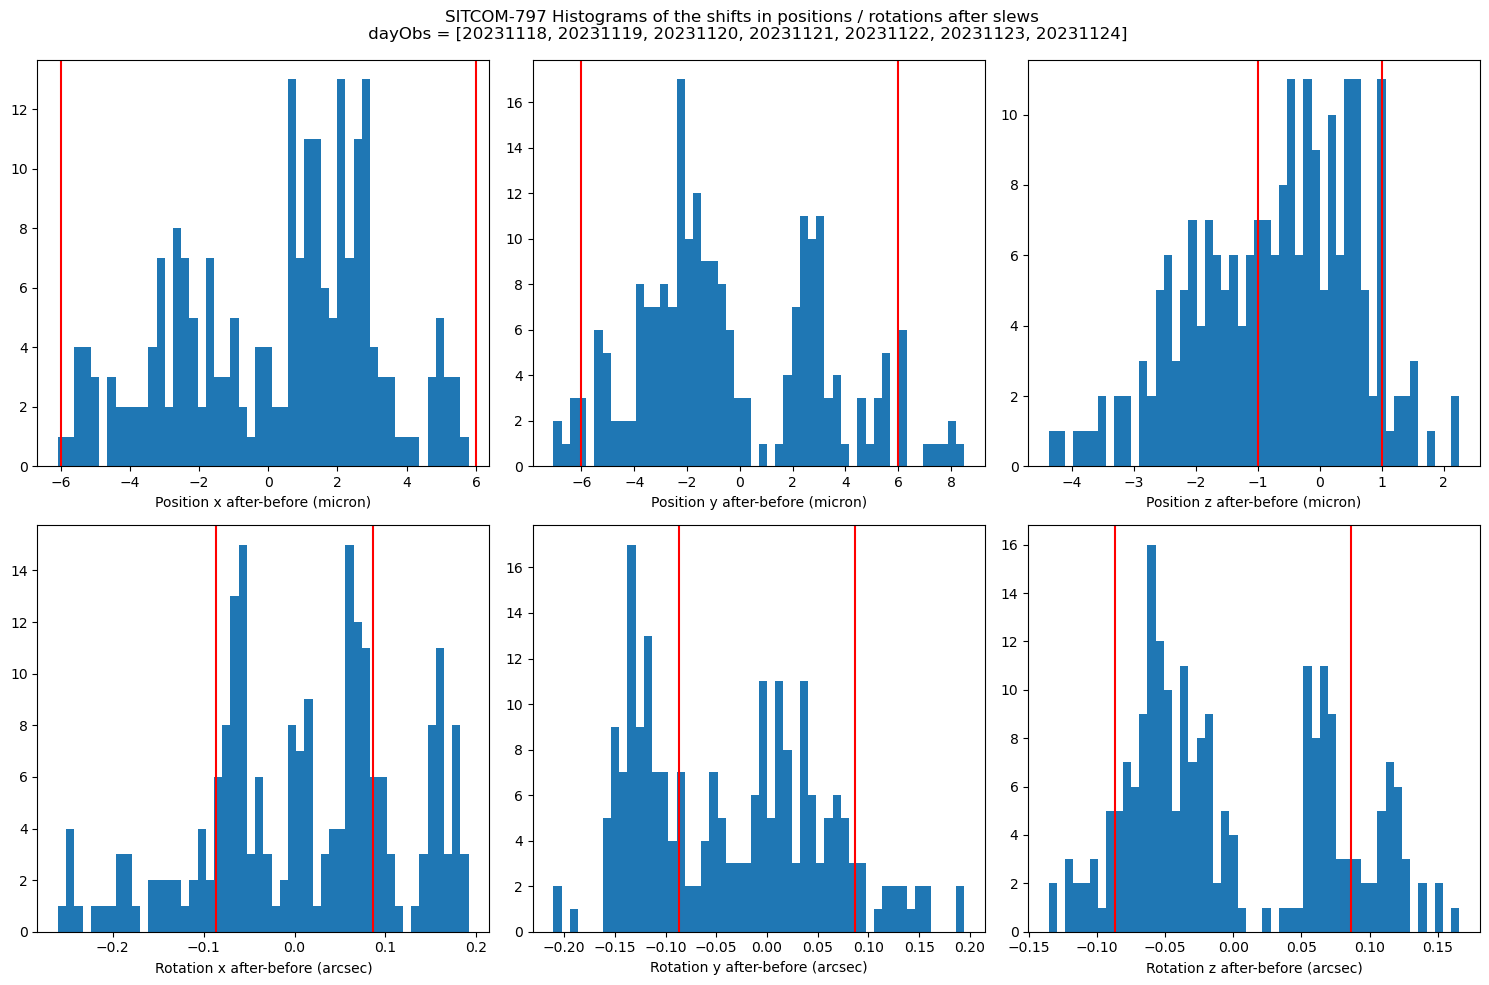

In [12]:
%matplotlib inline

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

axes = "xyz"

# limit on position (micron) or rotation (arcsec) for outliers
out_limit_pos = 500
out_limit_rot = 0.55

title = f"SITCOM-797 Histograms of the shifts in positions / rotations after slews \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 10))

# Check whether the TMA actually move in azimuth and not in elevation
mask_move = (abs(results["start_azi"] - results["end_azi"]) > 20) & (
    abs(results["start_ele"] - results["end_ele"]) < 1
)

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = np.abs(diff) < out_limit_pos
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    axs[0][i].hist(diff[mask], bins=50)
    axs[0][i].set_xlabel(f"Position {axes[i]} after-before (micron)")

    R_diff = (
        results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    axs[1][i].hist(R_diff[mask], bins=50)
    axs[1][i].set_xlabel(f"Rotation {axes[i]} after-before (arcsec)")

    # add lines and labels for tolerances
    if axes[i] in ["x", "y"]:
        axs[0][i].axvline(6, color="r")
        axs[0][i].axvline(-6, color="r")

        axs[1][i].axvline(0.0864, color="r")
        axs[1][i].axvline(-0.0864, color="r")

    else:
        axs[0][i].axvline(1, color="r")
        axs[0][i].axvline(-1, color="r")

        axs[1][i].axvline(0.0864, color="r")
        axs[1][i].axvline(-0.0864, color="r")

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.93)

## Conclusion

The mirror displacement during slew is out of specifications, especially for what concerns the piston (z position)

## Check whether the mirror displacement is correlated to the elevation difference ( end of slew - start of slew)

Found 4 outliers xPosition (limit: 100 microns)
Found 79 outliers xRotation (limit: 0.55 arcsec)
Found 12 outliers yPosition (limit: 100 microns)
Found 41 outliers yRotation (limit: 0.55 arcsec)
Found 9 outliers zPosition (limit: 100 microns)
Found 12 outliers zRotation (limit: 0.55 arcsec)


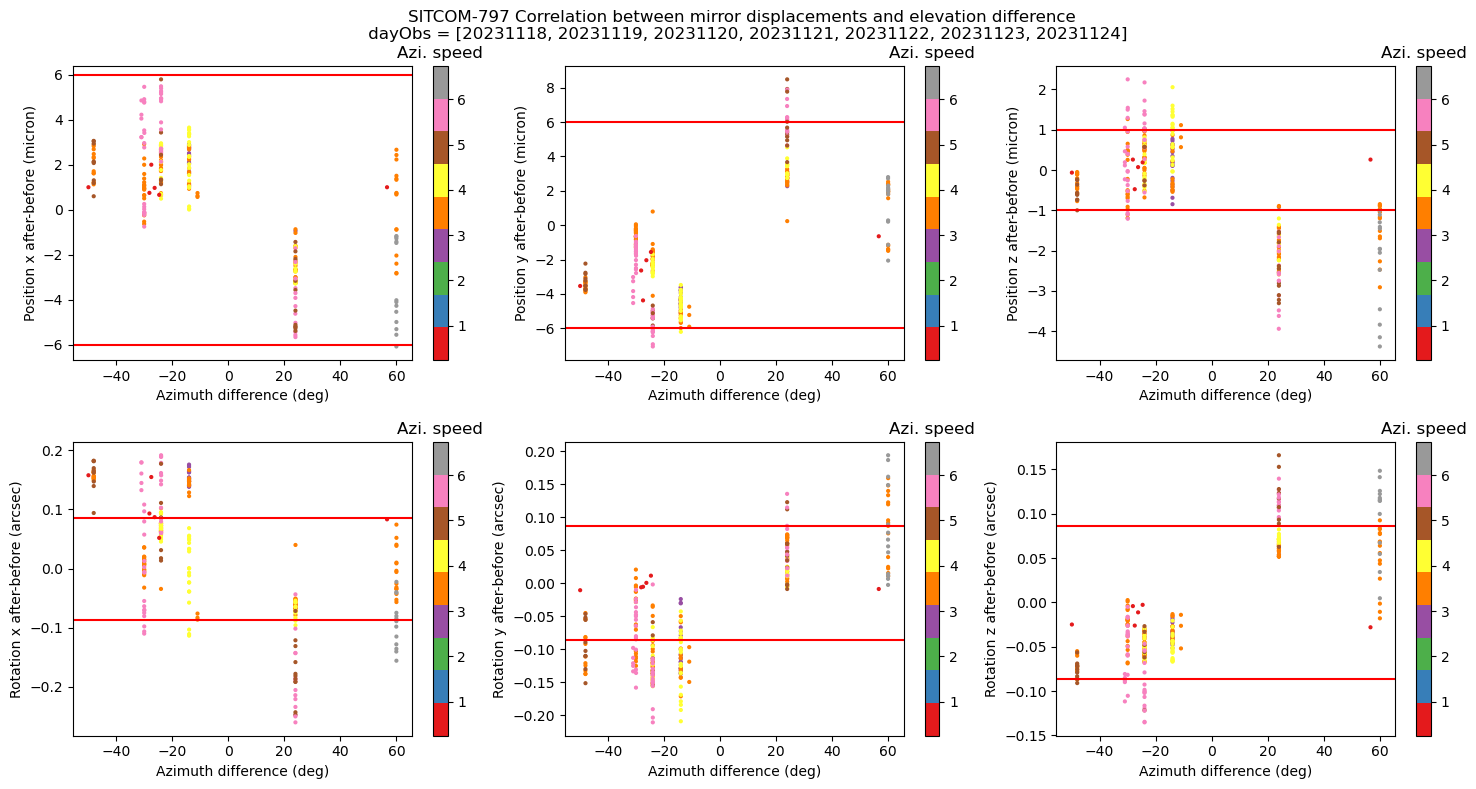

In [13]:
# The color scale represents the slew speed

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

plt.rc("text", usetex=False)

cm = matplotlib.colormaps["Set1"]

axes = ["x", "y", "z"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Correlation between mirror displacements and elevation difference \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in azimuth and not in elevation
mask_move = (abs(results["start_azi"] - results["end_azi"]) > 10) & (
    abs(results["start_ele"] - results["end_ele"]) < 1
)

diff_azi = results["end_azi"] - results["start_azi"]

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = np.abs(diff) < out_limit_pos
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    im = axs[0][i].scatter(
        diff_azi[mask], diff[mask], c=abs(results["speed_azi"][mask]), s=4, cmap=cm
    )
    axs[0][i].set_xlabel("Azimuth difference (deg)")
    axs[0][i].set_ylabel(f"Position {axes[i]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title("Azi. speed")

    R_diff = (
        results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    im = axs[1][i].scatter(
        diff_azi[mask], R_diff[mask], c=abs(results["speed_azi"][mask]), s=4, cmap=cm
    )
    axs[1][i].set_xlabel("Azimuth difference (deg)")
    axs[1][i].set_ylabel(f"Rotation {axes[i]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title("Azi. speed")

    if axes[i] in ["x", "y"]:
        axs[0][i].axhline(6, color="r")
        axs[0][i].axhline(-6, color="r")

        axs[1][i].axhline(0.0864, color="r")
        axs[1][i].axhline(-0.0864, color="r")

    else:
        axs[0][i].axhline(1, color="r")
        axs[0][i].axhline(-1, color="r")

        axs[1][i].axhline(0.0864, color="r")
        axs[1][i].axhline(-0.0864, color="r")

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

In [20]:
np.sum(mask_move)

275

## Scatter plots to check the correlations between the various mirror movements and rotations

Found 12 outliers for pair xy (limit: 100 microns)
Found 79 outliers for pair xy (limit: 0.55 arcsec)
Found 12 outliers for pair yz (limit: 100 microns)
Found 43 outliers for pair yz (limit: 0.55 arcsec)
Found 11 outliers for pair xz (limit: 100 microns)
Found 79 outliers for pair xz (limit: 0.55 arcsec)


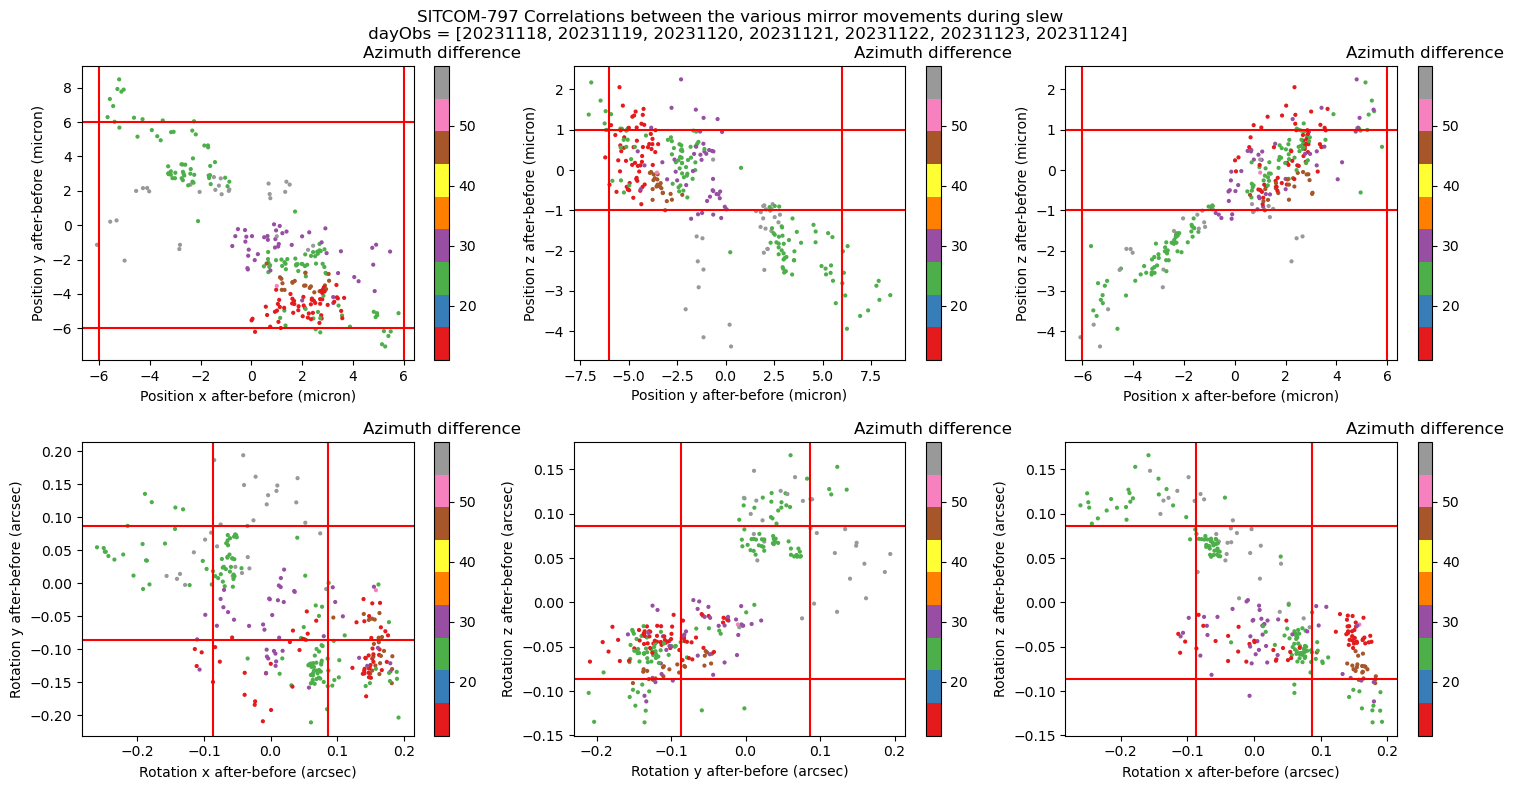

In [14]:
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

cm = matplotlib.colormaps["Set1"]

pairs = ["xy", "yz", "xz"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Correlations between the various mirror movements during slew  \n dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in azimuth and not in elevation
mask_move = (abs(results["start_azi"] - results["end_azi"]) > 10) & (
    abs(results["start_ele"] - results["end_ele"]) < 1
)

# Azimuth change
diff_azi = results["end_azi"] - results["start_azi"]

for i in range(3):
    pair = pairs[i]

    # Positions
    diff_1 = (results[f"{pair[0]}_after"] - results[f"{pair[0]}_before"]) * u.mm.to(
        u.micron
    )
    diff_2 = (results[f"{pair[1]}_after"] - results[f"{pair[1]}_before"]) * u.mm.to(
        u.micron
    )
    mask_out = (np.abs(diff_1) < out_limit_pos) & (np.abs(diff_2) < out_limit_pos)
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_pos} microns)"
    )
    mask = mask_out & mask_move
    im = axs[0][i].scatter(
        diff_1[mask], diff_2[mask], c=abs(diff_azi[mask]), s=4, cmap=cm
    )
    axs[0][i].set_xlabel(f"Position {pair[0]} after-before (micron)")
    axs[0][i].set_ylabel(f"Position {pair[1]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title("Azimuth difference")

    if pair[0] == "x" or pair[0] == "y":
        axs[0][i].axvline(6, color="r")
        axs[0][i].axvline(-6, color="r")
    else:
        axs[0][i].axvline(1, color="r")
        axs[0][i].axvline(-1, color="r")

    if pair[1] == "x" or pair[1] == "y":
        axs[0][i].axhline(6, color="r")
        axs[0][i].axhline(-6, color="r")
    else:
        axs[0][i].axhline(1, color="r")
        axs[0][i].axhline(-1, color="r")

    # Rotations
    R_diff_1 = (
        results[f"R_{pair[0]}_after"] - results[f"R_{pair[0]}_before"]
    ) * u.degree.to(u.arcsec)
    R_diff_2 = (
        results[f"R_{pair[1]}_after"] - results[f"R_{pair[1]}_before"]
    ) * u.degree.to(u.arcsec)
    mask_out = (np.abs(R_diff_1) < out_limit_rot) & (np.abs(R_diff_2) < out_limit_rot)
    print(
        f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_rot} arcsec)"
    )
    mask = mask_out & mask_move
    im = axs[1][i].scatter(
        R_diff_1[mask], R_diff_2[mask], c=abs(diff_azi[mask]), s=4, cmap=cm
    )
    axs[1][i].set_xlabel(f"Rotation {pair[0]} after-before (arcsec)")
    axs[1][i].set_ylabel(f"Rotation {pair[1]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title("Azimuth difference")

    axs[1][i].axhline(0.0864, color="r")
    axs[1][i].axhline(-0.0864, color="r")
    axs[1][i].axvline(0.0864, color="r")
    axs[1][i].axvline(-0.0864, color="r")

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

## Conclusions

 - We observe clear correlations between the mirror displacements / rotations during slews
 - The amplitude of the displacements / rotations is also correlated to the elevation difference

# Detailed analysis of a specific slew

## We select one specific large amplitude slew in order to analyse the variation of the positions / rotations as a function of time 

In [ ]:
# Find the slew where the elevation difference is maximum
ele_index = np.argmax(diff_ele)
# ele_index=19
# ele_index=14
print(
    "Elevation difference of slew %i: %.1f degrees" % (ele_index, diff_ele[ele_index])
)
print(
    "Start elevattion is %.1f degrees - End elevation is %.1f degrees"
    % (results["start_ele"][ele_index], results["end_ele"][ele_index])
)

In [ ]:
# Get ims data covering the selected slew plus some extra time before and after the slew
delta_t = 40
dt_end = time.TimeDelta(delta_t, format="sec")
dt_begin = time.TimeDelta(delta_t, format="sec")
df_ims = getEfdData(
    client,
    "lsst.sal.MTM1M3.imsData",
    begin=slews[ele_index].begin - dt_begin,
    end=slews[ele_index].end + dt_end,
)

# We also retreive the data correesponding to the exact slew duration in order to be able to find the start and the end of the slew
df_ims_slew = getEfdData(
    client,
    "lsst.sal.MTM1M3.imsData",
    begin=slews[ele_index].begin,
    end=slews[ele_index].end,
)

In [ ]:
# Plot positions and rotation versus time

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = (
    "SITCOM-797 Variation of the positions / rotations during a large amplitude slew \n\n Start elev. %.1f deg - End elev. %.1f deg"
    % (
        results["start_ele"][ele_index],
        results["end_ele"][ele_index],
    )
)
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(18, 10))

axes = "xyz"
for i in range(3):
    axis = axes[i]

    # Positions
    _ = axs[0][i].plot(
        df_ims.index,
        (
            results[f"{axis}_before"][ele_index]
            - df_ims[f"{axis}Position"] * u.m.to(u.mm)
        )
        * u.mm.to(u.micron),
    )
    axs[0][i].axvline(df_ims_slew.index[0], c="r")
    axs[0][i].axvline(df_ims_slew.index[-1], c="r")
    axs[0][i].set_xlabel("Time")
    axs[0][i].set_ylabel(f"{axis} position (ims) displacement in micron")
    axs[0][i].xaxis.set_major_formatter(formatter)

    # Rotations
    _ = axs[1][i].plot(
        df_ims.index,
        (results[f"R_{axis}_before"][ele_index] - df_ims[f"{axis}Rotation"])
        * u.degree.to(u.arcsec),
    )
    axs[1][i].axvline(df_ims_slew.index[0], c="r")
    axs[1][i].axvline(df_ims_slew.index[-1], c="r")
    axs[1][i].set_xlabel("Time")
    axs[1][i].set_ylabel(f"{axis} rotation (ims) change in arcsec")
    axs[1][i].xaxis.set_major_formatter(formatter)

axs[0][0].text(
    0.09,
    0.8,
    "Slew starts",
    rotation=90,
    transform=axs[0][0].transAxes,
    color="r",
)

axs[0][0].text(
    0.84,
    0.2,
    "Slew ends",
    rotation=90,
    transform=axs[0][0].transAxes,
    color="r",
)

fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

## Conclusion

From the previous plots we see that apart from a few glitches at the beginning and the end of the slews, M1M3 is moving smoothly during the slew.

In [36]:
from astropy import time 

slew = slews[55]
df_ims = getEfdData(client, "lsst.sal.MTM1M3.imsData", event=slew)

In [75]:
from astropy import time 

slew = slews[109]
print(slew.begin.datetime64, slew.end.datetime64)
delta_t = 1000
dt = time.TimeDelta(delta_t, format="sec")

df_ims = getEfdData(client, "lsst.sal.MTM1M3.imsData", begin=slew.begin-dt, end=slew.end+dt)

2023-11-22T02:00:30.353625298 2023-11-22T02:00:30.367074490


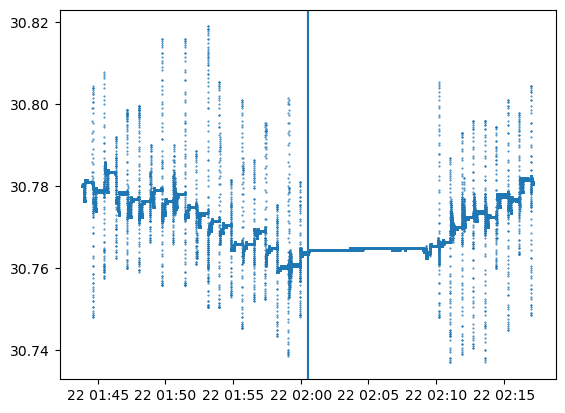

In [76]:
plt.scatter(df_ims.index, df_ims['rawSensorData0'], s=0.2)
plt.axvline(slew.begin.datetime64)
plt.axvline(slew.end.datetime64)

In [54]:
print(slew.begin.datetime64, slew.end.datetime64)

2023-11-19T19:06:29.320597172 2023-11-19T19:06:53.334587574


In [63]:
t = slew.begin

In [64]:
t

<Time object: scale='utc' format='unix' value=1700420789.3205972>

In [66]:
t.datetime64

numpy.datetime64('2023-11-19T19:06:29.320597172')